<a href="https://colab.research.google.com/github/fabrizi0rigodanz0/Airbnb_ML_Project/blob/main/Bitcoin_Transactions_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Bitcoin Transactions with Pandas and Spark

In [4]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [5]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.10+7-1~22.04.1 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.10+7-1~22.04.1 [71.1 MB]
Fetched 119 MB in 1s (81.8 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 1

## Setup

The following cell will import the used packages.

In [6]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

In [7]:
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *

## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [16]:
DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
TXDATA_FILE = "0-68732.csv.gz"

# Larger dataset
TXDATA_FILE2 = "224001-234000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769663
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661019
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445208
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3848932
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3771780
First block : 300001


In [ ]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

In [ ]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE2)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df = df.sample(frac=1/10, random_state=42)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE2)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset = dataset.sample(fraction=1/10, seed=42)
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes

           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Part 0

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE2)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
#outputDF[["Output","Value"]] = outputDF["Output"].to_list()
outputDF = outputDF.dropna(subset=['Output'])  # Remove NaNs if any
outputDF['Output'], outputDF['Value'] = zip(*outputDF['Output'].apply(lambda x: x if len(x) == 2 else (None, None)))

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                     cnt_in   cnt_out       cnt
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp  156000.0  154285.0  310285.0
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6  145342.0  145236.0  290578.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   89521.0   89427.0  178948.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx   69890.0   69741.0  139631.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn   63969.0   63892.0  127861.0
1VayNert3x1KzbpzMGt2qdqrAThiRovi8   52129.0   52297.0  104426.0
1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc   50376.0   50032.0  100408.0
1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY   44032.0   44241.0   88273.0
1dice6YgEVBf88erBFra9BHf6ZMoyvG88   39163.0   39059.0   78222.0
1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1   37015.0   36795.0   73810.0
Runtime = 235.94536519050598


### Results (Pandas)

The time to process the small dataset was : **0.8033947944641113** seconds.

The time to process the large dataset was : **235.94536519050598** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE2)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-----------------------------------+------+------+-------+
|addr                               |cnt   |cnt_in|cnt_out|
+-----------------------------------+------+------+-------+
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp'|310285|156000|154285 |
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6'|290578|145342|145236 |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw'|178948|89521 |89427  |
|'1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx'|139631|69890 |69741  |
|'1dice7W2AicHosf5EL3GFDUVga7TgtPFn'|127861|63969 |63892  |
|'1VayNert3x1KzbpzMGt2qdqrAThiRovi8'|104426|52129 |52297  |
|'1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc'|100408|50376 |50032  |
|'1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY'|88273 |44032 |44241  |
|'1dice6YgEVBf88erBFra9BHf6ZMoyvG88'|78222 |39163 |39059  |
|'1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1'|73810 |37015 |36795  |
+-----------------------------------+------+------+-------+

Runtime = 109.76431059837341


### Results (Spark)

The time to process the small dataset was : **1.6324033737182617** seconds.

The time to process the large dataset was : **109.18929481506348** seconds.



### Discussion:

PySpark is ideal for large databases due to its distributed computing and in-memory processing, enabling fast, parallel processing of big data across multiple machines. This is the reason why it is much faster than pandas in doing calculations on the larger dataset.
However the parallel processing metod utilized is not efficient when dealing with small dataset as transferring data from a machine to another is an expensive task in terms of time.
For this reason Pandas is better for smaller datasets. It operates efficiently on a single machine with an in-memory data structure, offering fast data manipulation with a simple syntax.



## Part 1

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
transactionSDF.createOrReplaceTempView("transactions")
top10 = spark.sql("""
    SELECT *
    FROM transactions
    ORDER BY Sum DESC
    LIMIT 10
""")
top10.show()


+---------+------+---------+-------------------+
|     txid|height|      sum|               time|
+---------+------+---------+-------------------+
|230689:12|230689|21434.684|2013-04-10 19:22:31|
| 224249:1|224249|21266.498|2013-03-04 16:43:10|
| 233977:0|233977|15116.423|2013-05-01 00:25:58|
| 231692:0|231692|  14999.0|2013-04-16 20:12:45|
| 233065:0|233065|14995.875|2013-04-25 12:12:28|
| 225171:0|225171|13854.495|2013-03-10 10:58:55|
|231521:39|231521|12653.816|2013-04-15 20:24:44|
| 226024:0|226024|11459.878|2013-03-15 16:39:43|
| 231849:0|231849|  11102.9|2013-04-17 18:13:53|
| 231889:6|231889|10838.701|2013-04-18 00:07:35|
+---------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
from pyspark.sql.types import DateType

priceSchema = StructType([
    StructField("Date", DateType()),
    StructField("Price", FloatType()),
])

# Load the CSV file into a Spark DataFrame
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
priceDF = spark.read.csv(path, schema=priceSchema, header=True)

priceDF.createOrReplaceTempView("price_data")

resultDF = spark.sql("SELECT * FROM price_data")


In [ ]:
from pyspark.sql.functions import to_date, to_timestamp, col

# Convert 'Time' to datetime format and create a 'Date' column in transactionSDF
transactionSDF = transactionSDF.withColumn("Time", to_timestamp("Time"))
transactionSDF = transactionSDF.withColumn("Date", to_date("Time"))

# Convert 'Date' to date format in priceDF
priceDF = priceDF.withColumn("Date", to_date("Date"))

transactionSDF.createOrReplaceTempView("transaction_data")
priceDF.createOrReplaceTempView("price_data")

# Joining the two datasets on 'Date'
df_joined = spark.sql("""
    SELECT t.*, p.Price, t.Sum * p.Price as USD_Value
    FROM transaction_data t
    JOIN price_data p ON t.Date = p.Date
""")

# Registering the joined DataFrame as a temporary view
df_joined.createOrReplaceTempView("joined_data")

# Calculating the 10 largest transactions in USD and displaying them
top_10 = spark.sql("""
    SELECT *
    FROM joined_data
    ORDER BY USD_Value DESC
    LIMIT 10
""")
top_10.show()

+----------+------+---------+-------------------+----------+-----+---------+
|      txid|height|      sum|               Time|      Date|Price|USD_Value|
+----------+------+---------+-------------------+----------+-----+---------+
| 230689:12|230689|21434.684|2013-04-10 19:22:31|2013-04-10|165.0|3536722.8|
|  233065:0|233065|14995.875|2013-04-25 12:12:28|2013-04-25|141.7|2124915.5|
|  233977:0|233977|15116.423|2013-05-01 00:25:58|2013-05-01|116.4|1759551.6|
| 230691:53|230691|  9434.66|2013-04-10 19:34:39|2013-04-10|165.0|1556718.9|
|232937:291|232937| 9976.466|2013-04-24 16:15:09|2013-04-24|154.2|1538371.0|
|  230684:0|230684|   9000.0|2013-04-10 18:52:41|2013-04-10|165.0|1485000.0|
|  233013:0|233013|  9999.99|2013-04-25 04:28:00|2013-04-25|141.7|1416998.6|
| 230707:15|230707|   7723.0|2013-04-10 21:45:59|2013-04-10|165.0|1274295.0|
|  231889:6|231889|10838.701|2013-04-18 00:07:35|2013-04-18|109.0|1181418.4|
| 231891:24|231891|10819.958|2013-04-18 00:07:47|2013-04-18|109.0|1179375.4|

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


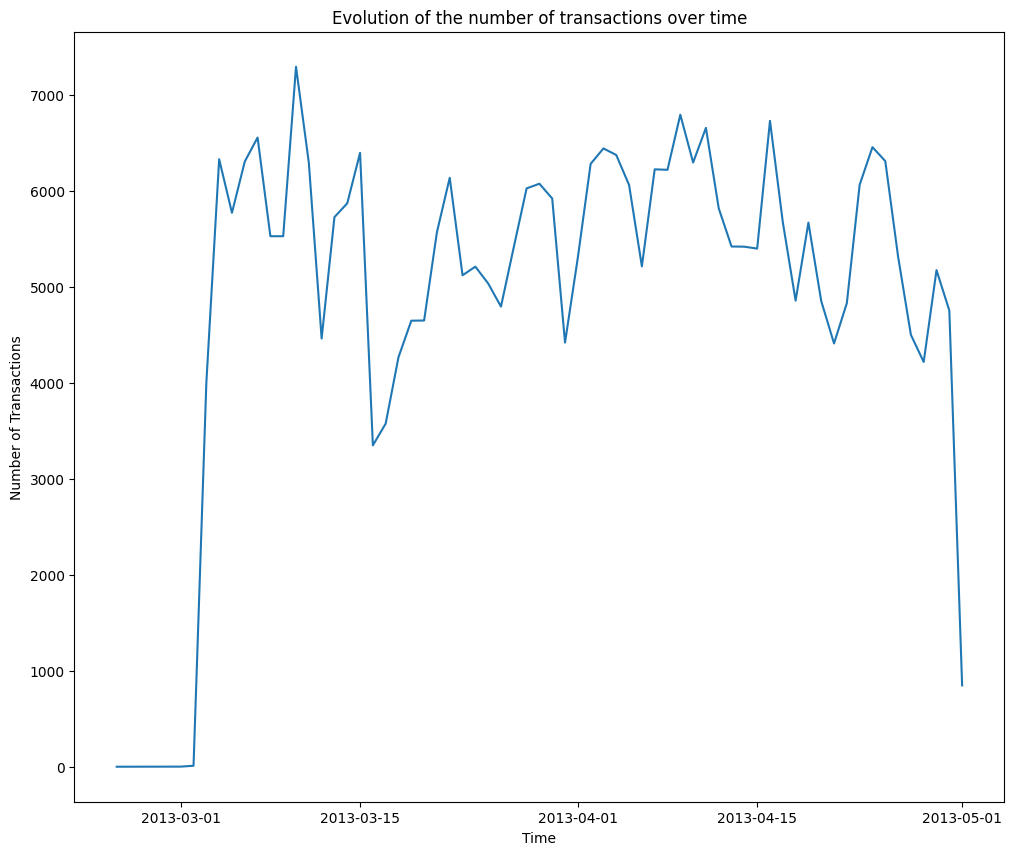

In [ ]:
from pyspark.sql.functions import to_date

# Convert 'Time' to date format
transactionSDF = transactionSDF.withColumn("Time", to_date("Time"))

transactionSDF.createOrReplaceTempView("transaction_data")

transactionDF3 = spark.sql("""
    SELECT Time, COUNT(*) as cnt
    FROM transaction_data
    GROUP BY Time
    ORDER BY Time
""")

import matplotlib.pyplot as plt

# Collect the data for plotting
plot_data = transactionDF3.collect()

# Extracting Time and cnt for plotting
times = [row['Time'] for row in plot_data]
counts = [row['cnt'] for row in plot_data]

# Plotting using Matplotlib
plt.figure(figsize=(12, 10))
plt.plot(times, counts)
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Evolution of the number of transactions over time')
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


In [ ]:
from pyspark.sql.functions import to_date, col

# Convert 'Date' to date format and sort priceDF
priceDF = priceDF.withColumn("Date", to_date("Date"))
priceDF = priceDF.orderBy("Date")

# Register priceDF as a temporary view
priceDF.createOrReplaceTempView("price_data")

# Group by 'Time' and sum the 'Sum' column in transactionSDF
transactionSDF.createOrReplaceTempView("transaction_data")
transactionDF4 = spark.sql("""
    SELECT Time, SUM(Sum) as Sum
    FROM transaction_data
    GROUP BY Time
""")

# Register the resulting DataFrame as a temporary view
transactionDF4.createOrReplaceTempView("grouped_transaction_data")

# Join the DataFrames
mergedDF = spark.sql("""
    SELECT t.Time, t.Sum, p.Price, (t.Sum * p.Price) as USD
    FROM grouped_transaction_data t
    INNER JOIN price_data p ON t.Time = p.Date
""")

# Rename 'Sum' to 'BTC'
mergedDF = mergedDF.withColumnRenamed("Sum", "BTC")

# Register the joined DataFrame as a temporary view
mergedDF.createOrReplaceTempView("merged_data")

# Order by 'Time'
mergedDF = spark.sql("""
    SELECT Time, BTC, USD
    FROM merged_data
    ORDER BY Time
""")


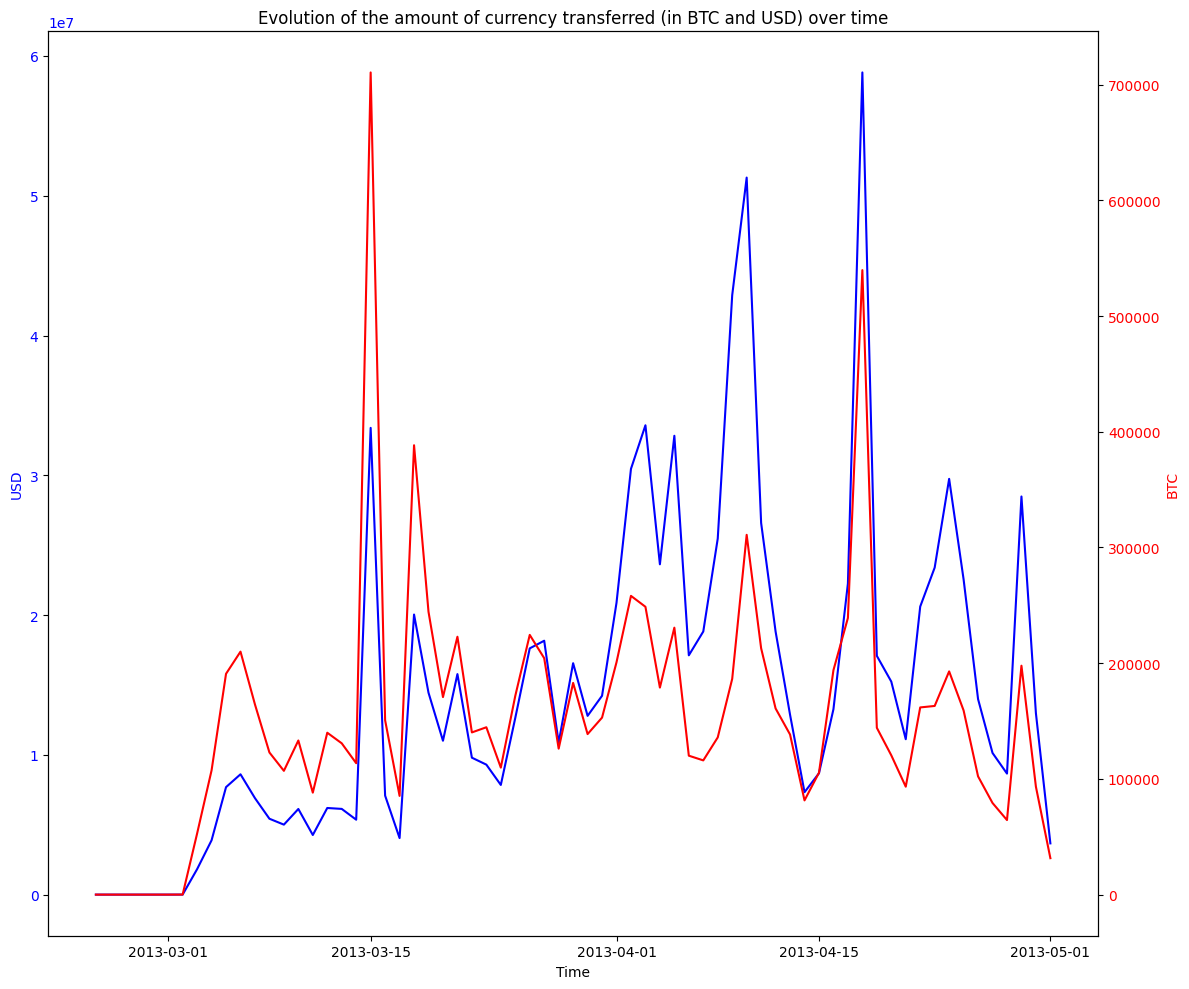

In [ ]:
import matplotlib.pyplot as plt

# Collect the data for plotting
plot_data = mergedDF.collect()

# Extract 'Time', 'BTC', and 'USD' for plotting
times = [row['Time'] for row in plot_data]
usd_values = [row['USD'] for row in plot_data]
btc_values = [row['BTC'] for row in plot_data]

# Creating the plot
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the 'USD' data
ax1.plot(times, usd_values, label='USD', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('USD', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for 'BTC'
ax2 = ax1.twinx()
ax2.plot(times, btc_values, label='BTC', color='r')
ax2.set_ylabel('BTC', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Evolution of the amount of currency transferred (in BTC and USD) over time')
fig.tight_layout()  # Adjust the layout
plt.show()

## Part 2

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [ ]:
df_joined = inputDF.join(outputDF.set_index('TxId'), on= 'TxId', how= 'outer', rsuffix='_output')
df_joined.drop(['Sum_output', 'Time_output'], axis= 1, inplace= True)


In [ ]:
# Group by 'Input' in input_df and sum the 'Sum' column
input_sums = inputDF.groupby('Input')['Sum'].sum()

# Group by 'Output' in output_df and sum the 'Value' column
output_sums = outputDF.groupby('Output')['Value'].sum()

# Combine the two series into a single dataframe, with input sums being subtracted and output sums added
balance_df = pd.DataFrame({'Balance': output_sums}).join(pd.DataFrame({'Balance': -input_sums}), how='outer', lsuffix='_out', rsuffix='_in')

# Fill NaN values with 0 and sum the balances
balance_df['Balance'] = balance_df.fillna(0)['Balance_out'] + balance_df.fillna(0)['Balance_in']

# Sort the dataframe by balance in descending order
balance_df = balance_df.sort_values(by='Balance', ascending=False)

In [ ]:
#IMPORTANT!! Restart the kernel without PySpark before running this
# Let's start by calculating some statistics, we'll start by calculating the age of each address:

# Convert the 'Time' column to datetime if not already done
inputDF['Time'] = pd.to_datetime(inputDF['Time'])
outputDF['Time'] = pd.to_datetime(outputDF['Time'])

# Calculate the earliest and latest times using pandas methods
earliest_time = min(inputDF['Time'].min(), outputDF['Time'].min())
latest_time = max(inputDF['Time'].max(), outputDF['Time'].max())
total_period = (latest_time - earliest_time).days

# Calculating the age of each address in days
first_input_time = inputDF.groupby('Input')['Time'].min()
first_output_time = outputDF.groupby('Output')['Time'].min()

# Combining the first transaction times
first_transaction_time = pd.concat([first_input_time, first_output_time], axis=1)
first_transaction_time['First_Time'] = first_transaction_time.min(axis=1)

# Calculating the age of each address
address_age = (latest_time - first_transaction_time['First_Time']).dt.days

# The 'address_age' series now contains the age of each address in days
address_age_df = address_age.reset_index()
address_age_df.columns = ['Address', 'address_age']
#address_age_df.head()

In [ ]:
# Calculate total transaction values for each address in the input and output dataframes
input_total_values = inputDF.groupby('Input')['Sum'].sum()
output_total_values = outputDF.groupby('Output')['Value'].sum()

# Calculate transaction counts for each address in the input and output dataframes
input_transaction_counts = inputDF.groupby('Input').size()
output_transaction_counts = outputDF.groupby('Output').size()

# Combine total values and counts for each address
total_values = input_total_values.add(output_total_values, fill_value=0)
transaction_counts = input_transaction_counts.add(output_transaction_counts, fill_value=0)

# Calculate the average transaction value for each address
average_transaction_values = total_values / transaction_counts

# Sort the series by average transaction value in descending order
average_transaction_values_sorted = average_transaction_values.sort_values(ascending=False)

average_transaction_values_sorted.head(10) # Display the top 10 addresses by average transaction value

# Convert the series to a DataFrame and reset the index
average_transaction_values_df = average_transaction_values_sorted.reset_index()
average_transaction_values_df.columns = ['Address', 'Average_Transaction_Value']


average_transaction_values_df['Average_Transaction_Value_Per_Day']= average_transaction_values_df['Average_Transaction_Value']/ total_period
average_transaction_values_df['Average_Transaction_Value_Per_Week']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/7)
average_transaction_values_df['Average_Transaction_Value_Per_Month']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/30)
average_transaction_values_df['Average_Transaction_Value_Per_Quarter']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/91)

#average_transaction_values_df.head()

In [ ]:
# Number of times that the address appears in the Input
N_of_input = inputDF.groupby('Input').size().astype(float)
N_of_input = N_of_input.reset_index()
N_of_input.columns = ['Address', 'N_of_Inputs']

#display(N_of_input.head())

# Number of times that the address appears in the Output
N_of_output = outputDF.groupby('Output').size()
N_of_output = N_of_output.reset_index()
N_of_output.columns = ['Address', 'N_of_Output']

#display(N_of_output.head())

# Merging the two datasets
input_output_df = N_of_input.merge(N_of_output, on='Address', how='left').fillna(0)
#display(input_output_df.head())

In [ ]:
# Extracting the 'Input' and 'Output' columns
input_addresses = inputDF['Input']
output_addresses = outputDF['Output']

# Concatenating and dropping duplicates to get unique addresses
unique_addresses = pd.concat([input_addresses, output_addresses]).drop_duplicates().reset_index(drop=True)

# Creating a new dataframe with these unique addresses
websiteDF = pd.DataFrame(unique_addresses, columns=['Address'])

websiteDF = websiteDF.merge(address_age_df, on='Address', how='left')

# Display the first few rows of the new dataframe
websiteDF = websiteDF.merge(balance_df, left_on='Address', right_index=True, how='left')

# Display the first few rows of the final merged dataframe
websiteDF = websiteDF.merge(input_output_df, on='Address', how='left').fillna(0)

# Merge the average transaction values DataFrame with the address_df DataFrame
websiteDF = websiteDF.merge(average_transaction_values_df, on='Address', how='left')

websiteDF

,Address,address_age,Balance_out,Balance_in,Balance,N_of_Inputs,N_of_Output,Average_Transaction_Value,Average_Transaction_Value_Per_Day,Average_Transaction_Value_Per_Week,Average_Transaction_Value_Per_Month,Average_Transaction_Value_Per_Quarter
0,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,62,5454.509437,-25515.019600,-20060.510164,14504.0,14324.0,1.074286,0.017327,0.12129,0.519816,1.576775
1,1HcdBWHCEkMf6WgTnjAse6Q5LWtNu5tAqW,32,0.000000,-1.732852,-1.732852,1.0,0.0,1.732852,0.027949,0.195645,0.838477,2.543379
2,1DASNHJLuqkwezyNLStC85s5d92FuutqiJ,17,0.014466,-0.012288,0.002178,1.0,1.0,0.013377,0.000216,0.00151,0.006473,0.019634
3,1EkUCz9okAjBofU7HEGXkNo61cCJTsqLPA,17,0.000000,-0.012288,-0.012288,1.0,0.0,0.012288,0.000198,0.001387,0.005946,0.018036
4,1C6K5PJUU8oe9GxVPDbRH1cs6FDbHMQNHs,23,0.000000,-23.322033,-23.322033,1.0,0.0,23.322033,0.376162,2.633133,11.284855,34.230726
...,...,...,...,...,...,...,...,...,...,...,...,...
619443,13FoML1UvV2YEjZud4Js4Jq1stLrSos8ie,10,0.120231,0.000000,0.120231,0.0,0.0,0.120231,0.001939,0.013574,0.058176,0.176468
619444,19udyqxHeoNRiHA6RF3zeCgw1qbn4xQorD,45,17.388604,0.000000,17.388604,0.0,0.0,17.388604,0.280461,1.963229,8.413841,25.521983
619445,1NGistC71QWeWE7Lp78pc91iyFxKqx1EWX,45,5.400000,0.000000,5.400000,0.0,0.0,5.4,0.087097,0.609677,2.612903,7.925806
619446,12RZy8rfyWY8GZX2uCMuadxYguvALQAPBa,32,40.377926,0.000000,40.377926,0.0,0.0,40.377926,0.651257,4.558798,19.537706,59.264376


#### Discussion

**1) Balance**

The code calculates the net balance for each address in a cryptocurrency transaction dataset by:

1. Summing the transaction amounts for each address in the 'Input' column of inputDF, which likely represents the total sent by each address.
2. Summing the transaction values for each address in the 'Output' column of outputDF, likely representing the total received.
3. Combining these sums into a single DataFrame, subtracting the inputs from the outputs to get a net balance for each address.
4. Filling any missing values with zero, since an outer join ensures all addresses are included, even if they don't appear in both DataFrames.
5. Sorting the DataFrame by balance in descending order to identify the addresses with the highest net balance.

**2) Address age**

This code calculates the age of each address in a dataset containing cryptocurrency transactions by:

1. Converting the 'Time' column in both inputDF and outputDF to datetime format.
2. Determining the earliest and latest transaction times across both datasets to establish the total period of the dataset.
3. Grouping transactions by 'Input' and 'Output' addresses to find the earliest transaction time for each address, representing when each address was first used.
4. Combining these times into a single DataFrame and calculating the first transaction time for each address.
5. Computing the age of each address in days by subtracting the first transaction time from the latest transaction time in the dataset.
6. Storing the results in a new DataFrame address_age_df with columns for 'Address' and 'address_age' (the latter representing each address's age in days).



**3) Average transcation values**

This code performs an analysis on cryptocurrency transaction data to determine the average transaction value for each address and then breaks down this average on a per-day, per-week, per-month, and per-quarter basis:

1. It calculates the total transaction value summed over all transactions for each address within the inputDF and outputDF DataFrames.
2. It counts the number of transactions for each address in both DataFrames.
3. These totals and counts are then combined across inputs and outputs, with missing values filled with 0, to ensure that all addresses are accounted for.
4. The average transaction value for each address is computed by dividing the total values by the transaction counts.
5. This average transaction value is sorted in descending order to identify the addresses with the highest average transaction values.
6. The sorted values are displayed for the top 10 addresses.
7. The series is then converted to a DataFrame, and the index is reset to create an 'Address' column.
8. Additional columns are added to the DataFrame to calculate the average transaction value per day, week, month, and quarter based on the total period of the dataset determined earlier.
9. The code to display the top entries of this DataFrame is commented out.

**4) N. of Input/Output**

I calculated the number of times each cryptocurrency address appeared in both the input and output datasets:

1. For the input dataset 'N_of_input', I counted the occurrences of addresses in the 'Input' column, converted the counts to floating-point values, and organized the results into a DataFrame.

2. For the output dataset 'N_of_output', I performed a similar counting process based on the 'Output' column.

3. I merged these two datasets 'input_output_df' by the 'Address' column, filling any missing values with zeros. This merged DataFrame provides the counts of appearances for each address in both input and output data.

